## Image Classification using torchflare. 
***
* We will use [hydra:cc](https://hydra.cc/) to manage our parameters. The parameters are saved in a config.yaml file.
* Dataset : https://www.kaggle.com/c/cifar-10
* Install nb_black: https://github.com/dnanhkhoa/nb_black

In [1]:
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import *

In [2]:
import numpy as np
import pandas as pd
import albumentations as A

from torchflare.datasets import SimpleDataloader, show_batch
from torchflare.experiments import Experiment
import torchflare.callbacks as cbs
import torchflare.metrics as metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [4]:
initialize(config_path="conf")
cfg = compose(config_name="config")

<IPython.core.display.Javascript object>

In [5]:
df = pd.read_csv("trainLabels.csv")
classes = df.label.unique().tolist()
class_to_idx = {value: key for key, value in enumerate(classes)}
df.label = df.label.map(class_to_idx)
df.id = df.id.astype(str)

<IPython.core.display.Javascript object>

In [6]:
from sklearn.model_selection import train_test_split

test_df = df.iloc[:10000, :]  # I took first 10000 entries as test data
data_df = df.iloc[10000:, :]
train_df, valid_df = train_test_split(data_df, test_size=0.3)

<IPython.core.display.Javascript object>

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
test_transform = transforms.Compose([transforms.ToTensor()])

train_dl = SimpleDataloader.image_data_from_df(
    df=train_df, augmentations=transform, **cfg.shared_data_params
).get_loader(batch_size=32, shuffle=True, num_workers=0)

valid_dl = SimpleDataloader.image_data_from_df(
    df=valid_df, augmentations=transform, **cfg.shared_data_params
).get_loader(batch_size=32, shuffle=False, num_workers=0)



<IPython.core.display.Javascript object>

In [8]:
callbacks = [instantiate(cfg.callbacks.early_stopping),
            instantiate(cfg.callbacks.model_checkpoint)]

metrics = [instantiate(cfg.metric)]


<IPython.core.display.Javascript object>

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


<IPython.core.display.Javascript object>

In [10]:
exp = Experiment(**cfg.experiment.constant_params)

<IPython.core.display.Javascript object>

In [11]:
exp.compile_experiment(
    model=Net(), callbacks=callbacks, metrics=metrics, **cfg.experiment.compile_params
)

<IPython.core.display.Javascript object>

In [12]:
exp.perform_sanity_check(train_dl)

Sanity Check Completed. Model Forward Pass and Loss Computation Successful
Output Shape : torch.Size([32, 10])
Loss for a batch :2.319761276245117


<IPython.core.display.Javascript object>

In [13]:
exp.run_experiment(train_dl=train_dl, valid_dl=valid_dl)

Epoch,train_loss,train_accuracy,val_loss,val_accuracy,Time
0,1.85949,0.32346,1.64748,0.39342,07:27
1,1.58279,0.42654,1.53536,0.43992,02:20
2,1.48230,0.46514,1.47553,0.45975,00:37
3,1.42118,0.48993,1.41484,0.48367,00:41
4,1.37100,0.51139,1.37386,0.49942,00:40


<IPython.core.display.Javascript object>

In [16]:
data = dict(cfg.shared_data_params)
# popping label_cols
_ = data.pop("label_cols")

test_dl = SimpleDataloader.image_data_from_df(
    df=test_df, augmentations=test_transform, **data
).get_loader(batch_size=32, shuffle=False)

<IPython.core.display.Javascript object>

In [17]:
# Inference
ops = []
for op in exp.infer(path="./models/cifar10.bin", test_loader=test_dl):
    _, y_pred = torch.max(op, dim=1)
    ops.extend(y_pred)

<IPython.core.display.Javascript object>

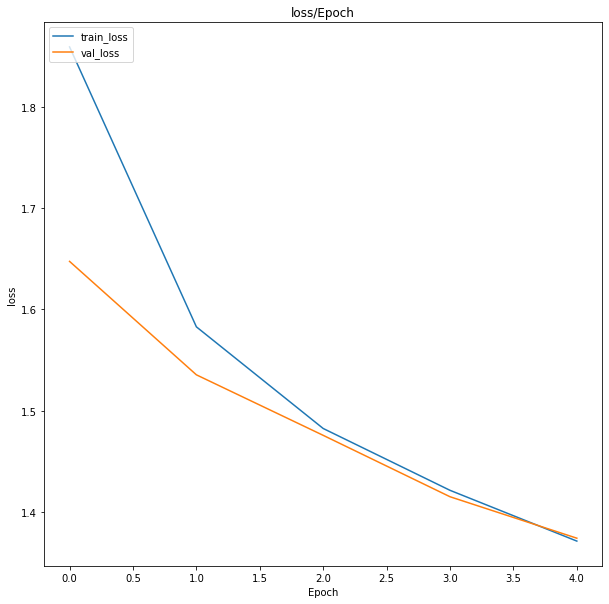

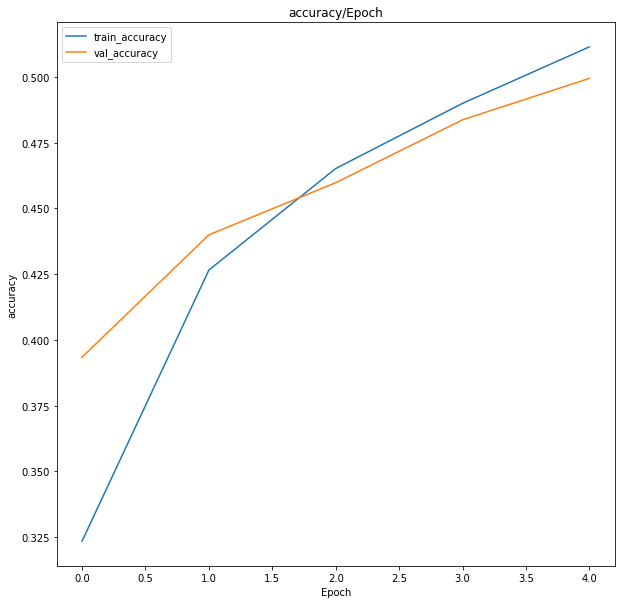

<IPython.core.display.Javascript object>

In [18]:
plot_metrics = ["loss", "accuracy"]
for metric in plot_metrics:
    exp.plot_history(key=metric, save_fig=False, plot_fig=True)